# Imports Required

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import scipy.stats as stats
import operator
from sklearn.metrics import roc_curve, auc
import random
import warnings
warnings.filterwarnings('ignore')


# Reading the data (Please run the cell and enter the input file path)

In [6]:
#Reading the data
#Enter the input file here
file_path = input("Please enter the input file path:")
#'/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/train.csv'
train_df = pd.read_csv(file_path)
n = 7000#number of rows from the dataframe
train_data_points = 1000 # number of training data points
#deleting the column 'id' from the dataframe as it is a unique and does not have any effect on the algorithm
del train_df['id']
#print (train_df.head())

Please enter the input file path:/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/train.csv


# Seperating the Categorical and Continuous Features

In [8]:
#creating 2 seperate dataframes for categorical and continuous features.
train_df_cat = pd.DataFrame()#training data frame with categorical features
train_df_cont = pd.DataFrame() #training data with continuous features
cat_list = []#list of categorical features
cont_list = []#list of continuous features

#populating the created data frames for categorical and continuous features
for each_column in train_df.columns:
    if train_df[each_column].dtype == 'float':
        cont_list.append(each_column)
cont_list.remove('loss')
for each_column in train_df.columns:
    if train_df[each_column].dtype == 'object':
        cat_list.append(each_column)

for i in range(0,len(cat_list)):
    train_df_cat[i] = train_df[cat_list[i]]
train_df_cat.columns =cat_list
for i in range(0,len(cont_list)):
    train_df_cont[i] = train_df[cont_list[i]]
train_df_cont.columns =cont_list


# Check for Missing Values in the data

In [ ]:
#checking for missing values:
print ("The total missing values in data",train_df.isnull().sum().sum())
#sum is 0 which indicates there are no misisng values in the training data.


# Categorizing the Continuous Features (Unsupervised Discretization using K - means)

In [17]:
feature_list = []

train_df_best_features = pd.DataFrame()
for each_column in train_df.columns:
    if train_df[each_column].dtype == 'float':
        feature_list.append(each_column)

best_features_train_df = pd.DataFrame()
for i in range(0,len(feature_list)):
    best_features_train_df[i] = train_df[feature_list[i] ]
best_features_train_df.columns =feature_list
print(best_features_train_df.shape)

(188318, 15)


# Finding the optimal value of K (Elbows method) 

## Kindly run the above cell if you want to RE-RUN this cell, as the 'loss' column is being deleted, it will throw a 'Keyerror'. So everytime you want to test this cell, re run above cell.

### This cell takes sometime, as it is trying to find the optimal value of k for all the 14 continuous features.

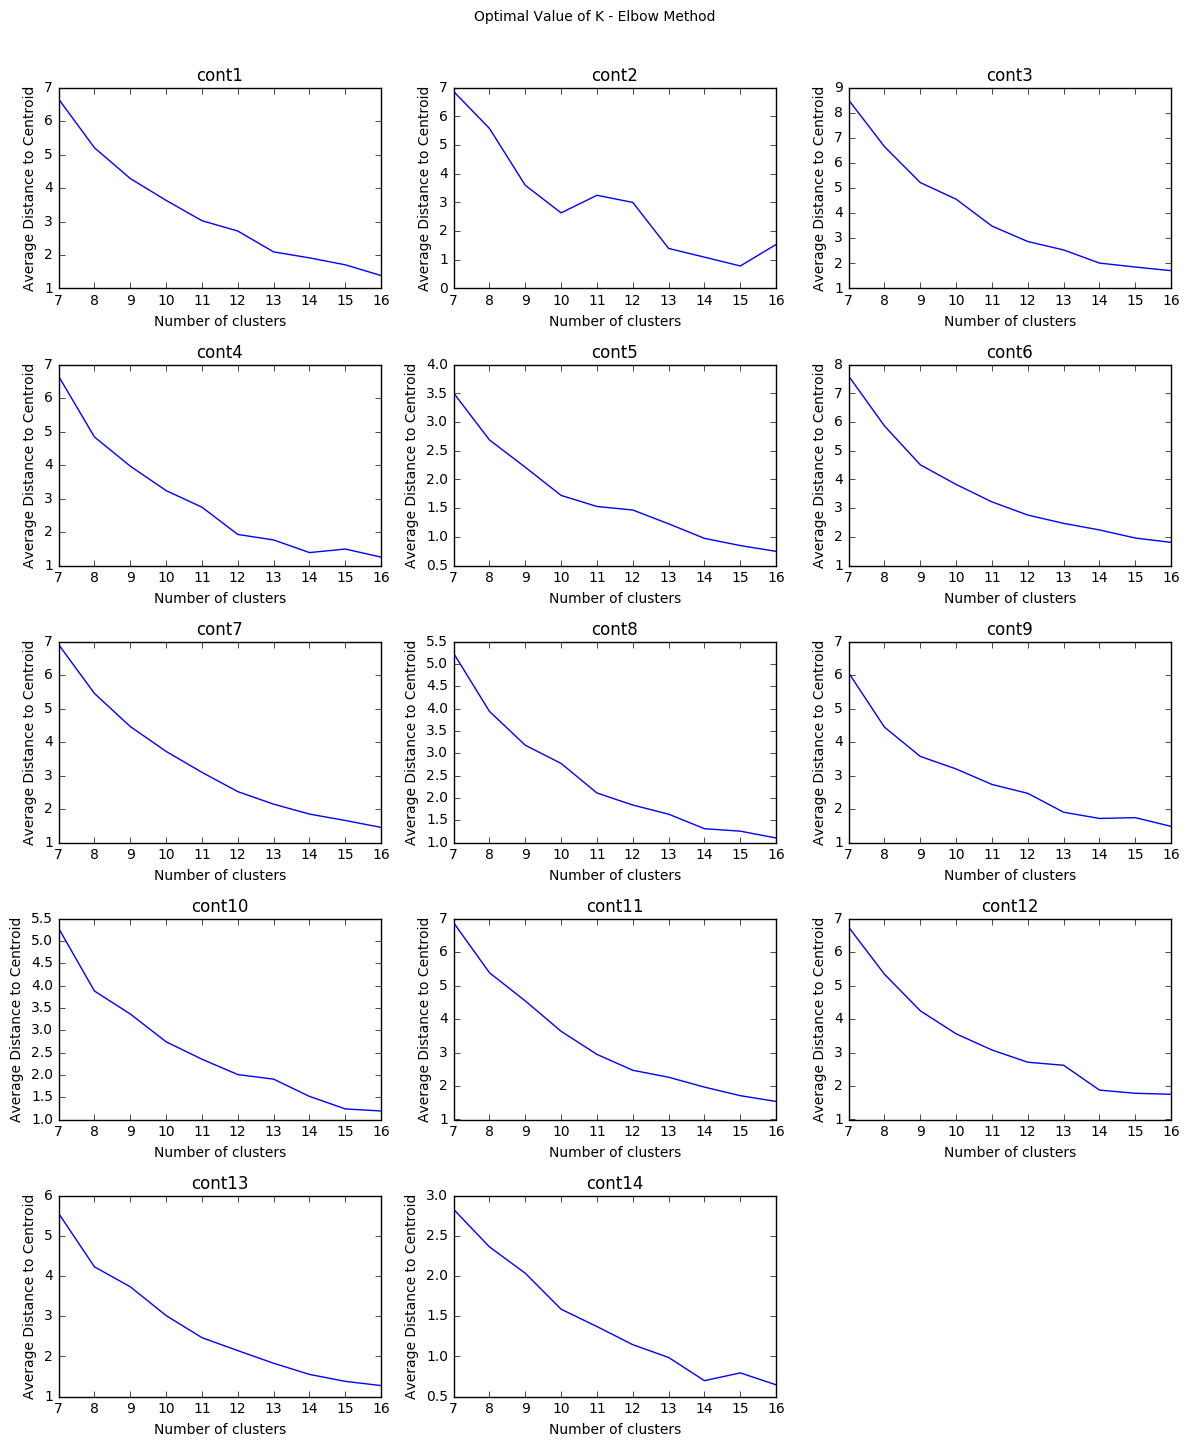

(7000, 14)


In [18]:
best_features_train_df =  best_features_train_df[:n]#nused
del best_features_train_df['loss']
#using elbows method to find the optimal value of k
from sklearn.cluster import KMeans,MiniBatchKMeans
from scipy.spatial.distance import cdist,pdist

count = 1
plt.figure(figsize = (12,14))
for each_column in best_features_train_df.columns:
    range_to_be_tested = range(7,17)
    feature_reconfigured = best_features_train_df[each_column].reshape(-1, 1)

    model_fit = [KMeans(n_clusters = n,init = 'random',n_init=10).fit(feature_reconfigured) for n in range_to_be_tested]
    cluster_centers = [each_model.cluster_centers_ for each_model in model_fit]
    #print (len(cluster_centers))
    #print (cluster_centers)
    euc_distance = [cdist(feature_reconfigured,each_center,'euclidean') for each_center in cluster_centers]   
    min_distance = [np.min(each_distance,axis = 1) for each_distance in euc_distance]
    #Calcuating the total sum of squares (SSE):

    tsse = sum(pdist(feature_reconfigured)**2)/feature_reconfigured.shape[0]
    #print ("tsse",tsse)
    #print (kmeans_optimal.inertia_)
    #calculating the sse between the clusters:
    wsse = [sum (eac_dist **2) for eac_dist in min_distance]
    bsse = tsse - wsse
    #print (wsse)
    y_axis = wsse  #bsse/tsse
    #print (bsse)
    #print (bsse/tsse)
    cluster_variance_dict = dict(zip(range(7,17),y_axis))
    #print ("The dictionary with number of clusters as key and the variance as value",cluster_variance_dict)
    
    plt.subplot(5, 3, count)
    count += 1
    plt.plot(range(7,17),y_axis)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average Distance to Centroid')
    plt.title(each_column)
plt.suptitle('Optimal Value of K - Elbow Method', y = 1.03)
plt.tight_layout()
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/kmeans.png")
plt.show()

#On analysing in all the 14 continuous features the variance stabilizes at 13 or 14 clusters. It makes sense because all 
#continuous features has values in the similar range. Hence choosing 13 clusters.

#In this case we also considered the effect of choosing initial centroids. By setting the parameter n_init = 10,
#each feature is clustered with 10 different value of initial centroids for each value of k, and the initial seed with 
#minimum sse is chosen.

print(best_features_train_df.shape)


# Performing the Discretization, after getting the optimal value of k from the graph

### 1. Please note that the optimal value of K - could change while testing, as the initial centroids differ.

### 2. 20 different initial centroids are used, the one with minimum Sum of Squared errors is chosen.

In [19]:
#Now that we have decided the optimal number of clusters for each feature, lets discretize the features.

from sklearn.cluster import KMeans,MiniBatchKMeans

print ("Before Clustring:")
print (best_features_train_df.head())

for each_column in best_features_train_df.columns:
    if each_column == 'cont4' or each_column == 'cont5' or each_column == 'cont6' or each_column == 'cont10' or each_column == 'cont11' or each_column == 'cont13':
        ftre = best_features_train_df[each_column].reshape(-1, 1)
        kmeans = KMeans(n_clusters = 13,init = 'random',n_init=20)
        model = kmeans.fit(ftre)   
        best_features_train_df[each_column] = kmeans.labels_
    else:
        ftre = best_features_train_df[each_column].reshape(-1, 1)
        kmeans = KMeans(n_clusters = 12,init = 'random',n_init=20)
        model = kmeans.fit(ftre)   
        best_features_train_df[each_column] = kmeans.labels_

#print (best_features_train_df.head())
print ('\t')
print ("After Clustring:")
print (best_features_train_df.head())


Before Clustring:
      cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
0  0.726300  0.245921  0.187583  0.789639  0.310061  0.718367  0.335060   
1  0.330514  0.737068  0.592681  0.614134  0.885834  0.438917  0.436585   
2  0.261841  0.358319  0.484196  0.236924  0.397069  0.289648  0.315545   
3  0.321594  0.555782  0.527991  0.373816  0.422268  0.440945  0.391128   
4  0.273204  0.159990  0.527991  0.473202  0.704268  0.178193  0.247408   

     cont8    cont9   cont10    cont11    cont12    cont13    cont14  
0  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493  0.714843  
1  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431  0.304496  
2  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709  0.774425  
3  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077  0.602642  
4  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011  0.432606  
	
After Clustring:
   cont1  cont2  cont3  cont4  cont5  cont6  cont7  cont8  cont9  cont10  \
0      2  

# Binarizing the continuous Attributes

## Please do not run this cell more than once, it will binarize the already binarized attributes.

In [20]:
best_features_train_df = best_features_train_df.astype('str')
column_list = best_features_train_df.columns
#print (best_features_train_df.shape)

train_df_cat_reduced = train_df_cat[:n] #nused
#Here will be the code to merge the clustered data frames after one hot encoding.

print ("Before Binarization:")
print ('\t')
print (train_df_cat_reduced.head())
for each_column in column_list:
    train_df_cat_reduced[each_column] = best_features_train_df[each_column]
    
#df_mod_onehotencoded will be the pre processed complete data including test and train
df_mod_onehotencoded = pd.get_dummies(train_df_cat_reduced)
df_mod_onehotencoded['loss'] = train_df[:n]['loss'] #nused
df_mod_onehotencoded = df_mod_onehotencoded.astype(int)

for index,each_row in df_mod_onehotencoded.iterrows():
    if each_row['loss'] < 2115.57:
        each_row['loss'] = 0
    else:
         each_row['loss'] = 1 #tobereplaced
df_mod_onehotencoded['loss'] = df_mod_onehotencoded['loss'].astype(int)
print ("After Binarization:")
print (df_mod_onehotencoded.head())




  cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9 cat10  ...   cat107 cat108  \
0    A    B    A    B    A    A    A    A    B     A  ...        J      G   
1    A    B    A    A    A    A    A    A    B     B  ...        K      K   
2    A    B    A    A    B    A    A    A    B     B  ...        F      A   
3    B    B    A    B    A    A    A    A    B     A  ...        K      K   
4    A    B    A    B    A    A    A    A    B     B  ...        G      B   

  cat109 cat110 cat111 cat112 cat113 cat114 cat115 cat116  
0     BU     BC      C     AS      S      A      O     LB  
1     BI     CQ      A     AV     BM      A      O     DP  
2     AB     DK      A      C     AF      A      I     GK  
3     BI     CS      C      N     AE      A      O     DJ  
4      H      C      C      Y     BM      A      K     CK  

[5 rows x 116 columns]
   cat1_A  cat1_B  cat2_A  cat2_B  cat3_A  cat3_B  cat4_A  cat4_B  cat5_A  \
0       1       0       0       1       1       0       0       1       1   

# Checking the Class Distribution

The number of data points are:
{0: 3482, 1: 3518}


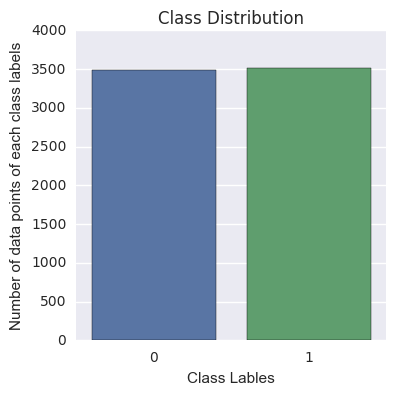

In [24]:
#We can see that the dataset is almost balanced
import seaborn as sns
y = df_mod_onehotencoded[['cat1_A','loss']].groupby("loss").count().values.tolist()
x = df_mod_onehotencoded[['cat1_A','loss']].groupby("loss").count().index.tolist()
for i in range(len(y)):
            y[i] = y[i][0]
print ("The number of data points are:")
print (dict(zip(x,y)))
%matplotlib inline
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.figure(figsize = (4,4))
sns.set(font_scale =  1)
sns.barplot(x, y,label = "big")
plt.title("Class Distribution")
plt.xlabel('Class Lables')
plt.ylabel('Number of data points of each class labels')
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/class_dist.png")
plt.show()

# Splitting the Training and Test Data

In [25]:
#Now that we have binarized the data using the one hot encoding, we have the data in the required format
#The next step is to apply feature selection and the machine learning algorithm

from sklearn.cross_validation import train_test_split
#getting the target column into a seperate dataframe
target_df = pd.DataFrame()
target_df ['loss'] = df_mod_onehotencoded['loss']
#Hence deleting the target column from the features data frame
del df_mod_onehotencoded['loss']
#splitting tha training data and testing data
# use train/test split with different random_state values
x_train, x_test, y_train, y_test = train_test_split(df_mod_onehotencoded, target_df, random_state=10)
#print (x_train.shape)
#print (y_train.shape)
#print (x_test.columns)


# Feature Selection (Chi2) : Filter Method

The top features with CHI- Square Feature selection


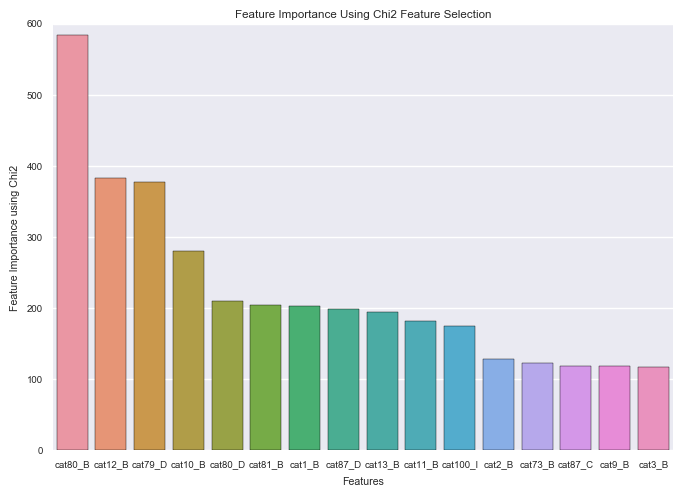

In [27]:
#Before applying the algorithm we will check the class balance in the data.
from math import isnan
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
chisqobj = SelectKBest(chi2, k=2)
fit = chisqobj.fit(x_train, y_train)
value_dict = dict(zip(df_mod_onehotencoded.columns,fit.scores_))
value_dict = {k: value_dict[k] for k in value_dict if not isnan(value_dict[k])}
sorted_important_features_list  = sorted(value_dict, key=value_dict.get,reverse = True)
#print (sorted_important_features_list)
#We have the list of the features, arranged in decsending order, i.e the feature with the maximum score will be the 
#first element in the list and so on.
#print (y_train.shape)
feature_list = [];feature_scores = [];
for i in range(0,16):
    feature_list.append(sorted_important_features_list[i])
    feature_scores.append(value_dict[sorted_important_features_list[i]])
%matplotlib inline
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
sns.set(font_scale =  .7)
sns.barplot(feature_list, feature_scores,label = "big")
print ("The top features with CHI- Square Feature selection")
plt.title("Feature Importance Using Chi2 Feature Selection")
plt.xlabel('Features')
plt.ylabel('Feature Importance using Chi2')
#plt.savefig('/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/chi2_ftre_imp.png')
plt.show()


#print (sorted_important_features_list)

# Combining Wrapper method Feature Selection (Forward Selection) with Filter Method (Chi2)

## Using 10 Fold Cross Valid with the above Combination for Tuning K in K - Nearest Neighbors

###  The next 3 cells for tuning k - nearest neighbor will take a while, as the number of computations are more 

The max accuracy for 100 top features 0.710258021625
The max accuracy for 200 top features 0.720930532001
The max accuracy for 300 top features 0.714268196978
The max accuracy for 400 top features 0.703023522729
The max accuracy for 500 top features 0.692355740671
The max accuracy for 600 top features 0.689505118775
The max accuracy for 700 top features 0.66951341441


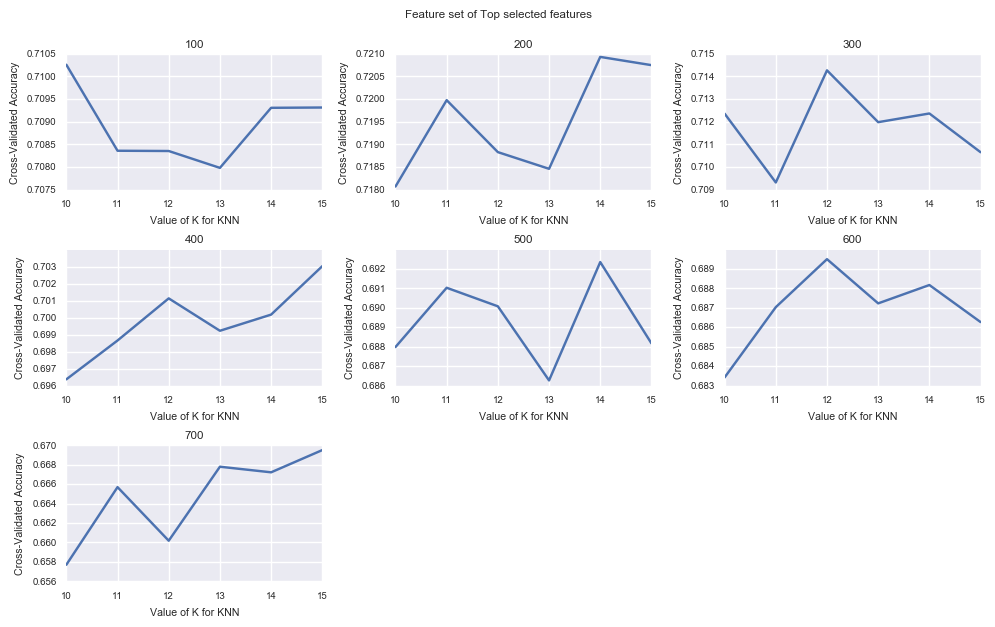

The top subset of features are: 200


In [29]:

#In the feature selection was not able to select the t - top features because, choosing k randomly might affect the 
#accuracy of the algorithm. We will now apply the k nn algorithm and select the optimal value of t(top features)
#and k (number of nearest neighbours using tuning set)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
ftre_list = [];score_list = [];
count = 1
plt.figure(figsize = (10,6))
for i in range(100,800,100):
    features = sorted_important_features_list[:i]
    #print ("here1")
    k_range = range(10, 16)
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k,weights='distance',algorithm='auto')      
        scores = cross_val_score(knn, x_train[features].values, y_train['loss'].values, cv=10, scoring='accuracy')
        #print ("here2")
        k_scores.append(scores.mean())
        #print ("here3")
    print("The max accuracy for",i,"top features",max(k_scores))
    ftre_list.append(str(i))
    score_list.append(max(k_scores))
    #print ("here4")
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.subplot(3, 3, count)
    count += 1
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title(i)
plt.suptitle('Feature set of Top selected features', y = 1.03)
plt.tight_layout()
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/knn_optimal_finder.png")
plt.show()
ftre_select_dict = dict(zip(ftre_list,score_list))

selected_ftre_count = int (max(ftre_select_dict, key=ftre_select_dict.get))
print ("The top subset of features are:",selected_ftre_count)

# Bias Variance Analysis of K-nn mode

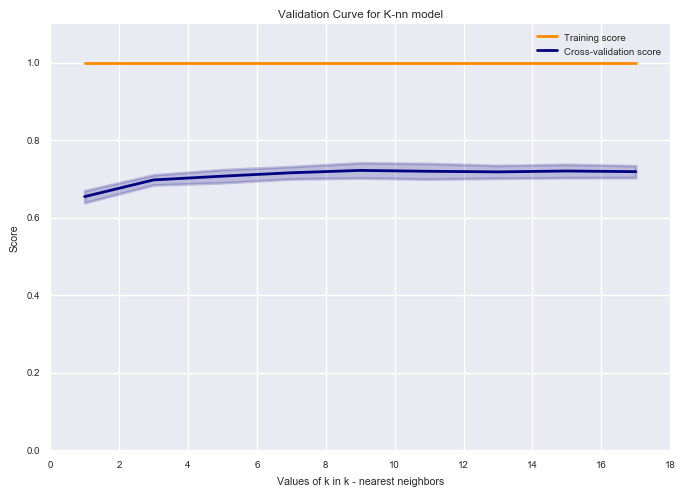

In [52]:

from sklearn.model_selection import validation_curve

X, y = x_train[sorted_important_features_list[0:selected_ftre_count]].values, y_train['loss'].values
param_range = range(1,18,2)
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(weights = 'distance'), X, y, param_name="n_neighbors", param_range=param_range,cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve for K-nn model")
plt.xlabel("Values of k in k - nearest neighbors")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/knn_valid_curve.png")
plt.show()

# Bias Variance analysis of Bagged K-nn model

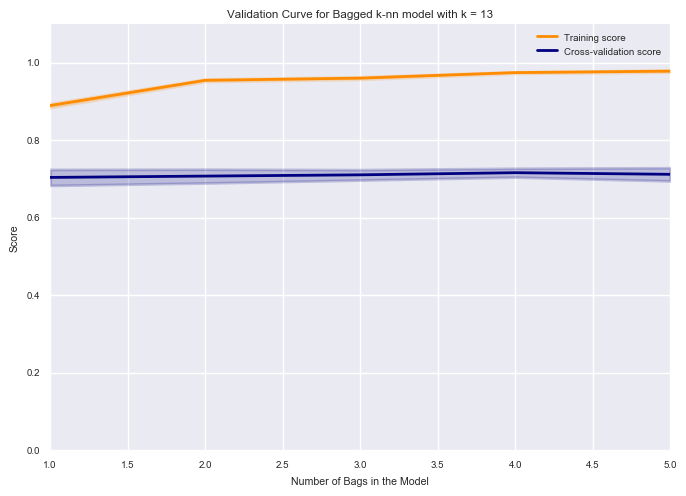

In [53]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import validation_curve

X, y = x_train[sorted_important_features_list[0:selected_ftre_count]].values, y_train['loss'].values

param_range = range(1,6)
train_scores, test_scores = validation_curve(
    BaggingClassifier(KNeighborsClassifier(n_neighbors=13,weights = 'distance')),X, y, param_name="n_estimators", param_range=param_range,cv=10, scoring="accuracy", n_jobs=1,
    )    
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve for Bagged k-nn model with k = 13")
plt.xlabel("Number of Bags in the Model")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/knn_bagging_valid_curve.png")
plt.show()

# Training and Prediction K-nn model

The accuracy of the classifier is 74.2285714286
The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}
The confusion matrix for the classifier:
[[772 126]
 [325 527]]
The number of true negatives: 772
The number of false negatives: 325
The number of false positive: 126
The number of true positive: 527
The True Positive Rate for the Model: 0.618544600939
The False Positive Rate for the Model: 0.140311804009


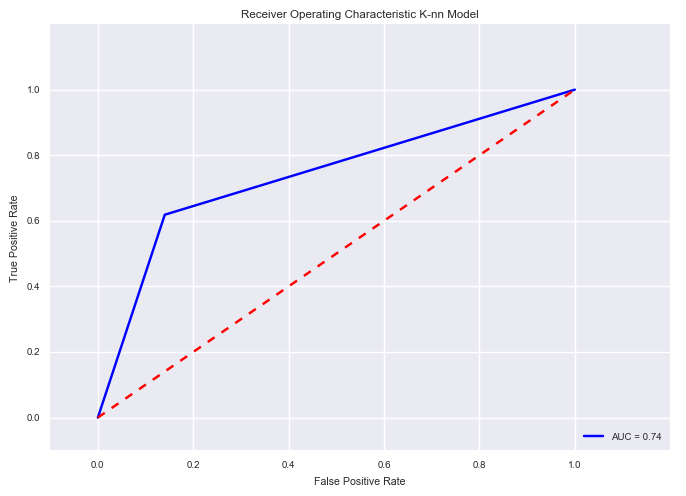

In [50]:
#Now that we have found the optimal number of features and value of k for the nearest neighbors using tuning set,
#lets apply the algorithm.

from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors=13,weights = 'uniform')
knn.fit(x_train[sorted_important_features_list[0:selected_ftre_count]].values, y_train['loss'].values)
y_pred_1 = knn.predict(x_test[sorted_important_features_list[0:selected_ftre_count]].values)
print("The accuracy of the classifier is",metrics.accuracy_score(y_test, y_pred_1)*100)

print ("The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}")
print ("The confusion matrix for the classifier:")
confusion_matrix_1  =  confusion_matrix(y_test, y_pred_1)
print (confusion_matrix_1)

print ("The number of true negatives:",confusion_matrix_1[0][0])
print ("The number of false negatives:",confusion_matrix_1[1][0])
print ("The number of false positive:",confusion_matrix_1[0][1])
print ("The number of true positive:",confusion_matrix_1[1][1])
print ("The True Positive Rate for the Model:",(confusion_matrix_1[1][1])/(confusion_matrix_1[1][1] + confusion_matrix_1[1][0]))
print ("The False Positive Rate for the Model:",(confusion_matrix_1[0][1])/(confusion_matrix_1[0][1] + confusion_matrix_1[0][0]))


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic K-nn Model')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/knn_roc.png")
plt.show()



# Training and Prediction: Bagged k - nearest neighbor model

The accuracy of the classifier is 74.2857142857
The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}
The confusion matrix for the classifier:
[[782 116]
 [334 518]]
The number of true negatives: 782
The number of false negatives: 334
The number of false positive: 116
The number of true positive: 518
The True Positive Rate for the Model: 0.607981220657
The False Positive Rate for the Model: 0.129175946548


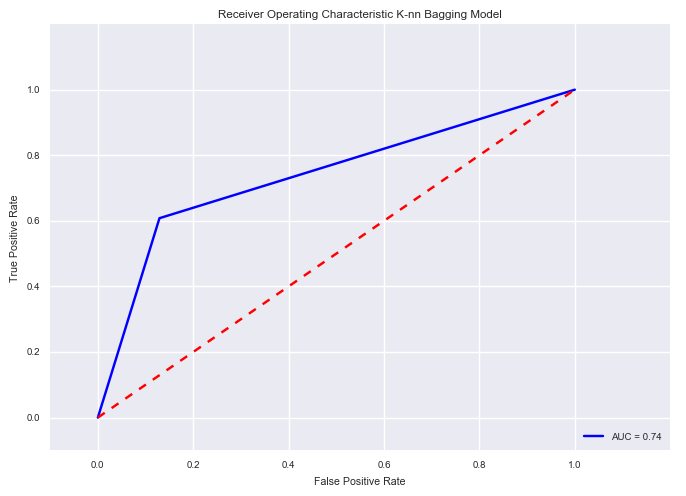

In [51]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

knn_bagger = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=13,weights = 'uniform'),n_estimators = 15,bootstrap_features = True)
knn_bagger.fit(x_train[sorted_important_features_list[0:selected_ftre_count]].values, y_train['loss'].values)
y_pred_1_bagger = knn_bagger.predict(x_test[sorted_important_features_list[0:selected_ftre_count]].values)
print("The accuracy of the classifier is",metrics.accuracy_score(y_test, y_pred_1_bagger)*100)

print ("The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}")
print ("The confusion matrix for the classifier:")
confusion_matrix_1_bagger  =  confusion_matrix(y_test, y_pred_1_bagger)
print (confusion_matrix_1_bagger)

print ("The number of true negatives:",confusion_matrix_1_bagger[0][0])
print ("The number of false negatives:",confusion_matrix_1_bagger[1][0])
print ("The number of false positive:",confusion_matrix_1_bagger[0][1])
print ("The number of true positive:",confusion_matrix_1_bagger[1][1])
print ("The True Positive Rate for the Model:",(confusion_matrix_1_bagger[1][1])/(confusion_matrix_1_bagger[1][1] + confusion_matrix_1_bagger[1][0]))
print ("The False Positive Rate for the Model:",(confusion_matrix_1_bagger[0][1])/(confusion_matrix_1_bagger[0][1] + confusion_matrix_1_bagger[0][0]))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_1_bagger)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic K-nn Bagging Model')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/knn_bagger_roc.png")
plt.show()


# Using 10 Fold Cross Valid with the above Combination for Tuning Depth in Decision Tree

The max accuracy for 100 top features 71.3136103607
The max accuracy for 200 top features 71.1044929011
The max accuracy for 300 top features 71.0472734131
The max accuracy for 400 top features 71.104441701
The max accuracy for 500 top features 71.0092036058
The max accuracy for 600 top features 71.0472988439
The max accuracy for 700 top features 71.0277940812


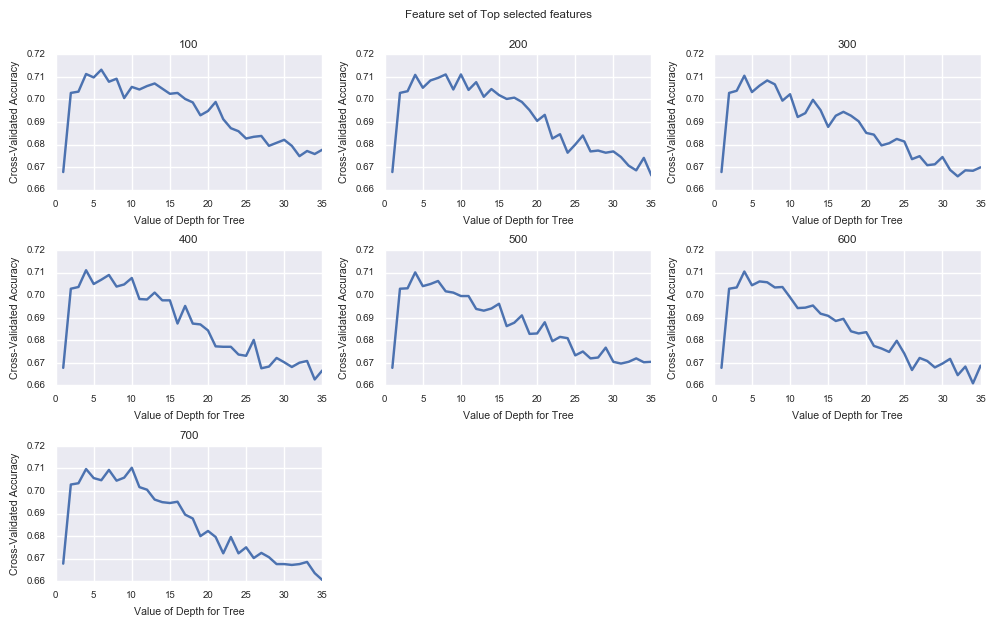

The top subset of features are: 100


In [32]:
from sklearn.tree import DecisionTreeClassifier
count = 1
plt.figure(figsize = (10,6))
dec_ftre_list = [];dec_score_list = [];
for i in range(100,800,100):
    #print ("here 2")
    features = sorted_important_features_list[:i]
    #print (features)
    k_range = range(1, 36)
    k_scores = []
    for k in k_range:
        tree = DecisionTreeClassifier(max_depth=k)
        scores = cross_val_score(tree, x_train[features].values, y_train['loss'].values, cv=7, scoring='accuracy')
       
        k_scores.append(scores.mean())
    print("The max accuracy for",i,"top features",max(k_scores)*100)

    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    dec_ftre_list.append(str(i))
    dec_score_list.append(max(k_scores))
    plt.subplot(3, 3, count)
    count += 1
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of Depth for Tree')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title(i)
plt.suptitle('Feature set of Top selected features', y = 1.03)
plt.tight_layout()
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/depth_tuning_graph.png")
plt.show()

sel_count_dict = dict(zip(dec_ftre_list,dec_score_list))
sel_count = int (max(sel_count_dict, key=sel_count_dict.get))
print ("The top subset of features are:",sel_count)


# Bias Variance Anaslysis of Decision Tree

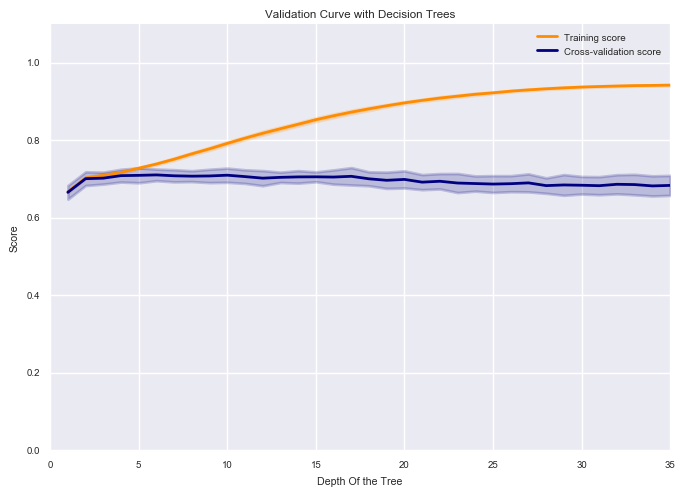

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve

X, y = x_train[sorted_important_features_list[0:sel_count]].values, y_train['loss'].values
param_range = range(1,36)
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(), X, y, param_name="max_depth", param_range=param_range,cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Decision Trees")
plt.xlabel("Depth Of the Tree")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/dtrees_valid_curve.png")
plt.show()

#  Bias Variance Analysis of Bagged Decision Tree

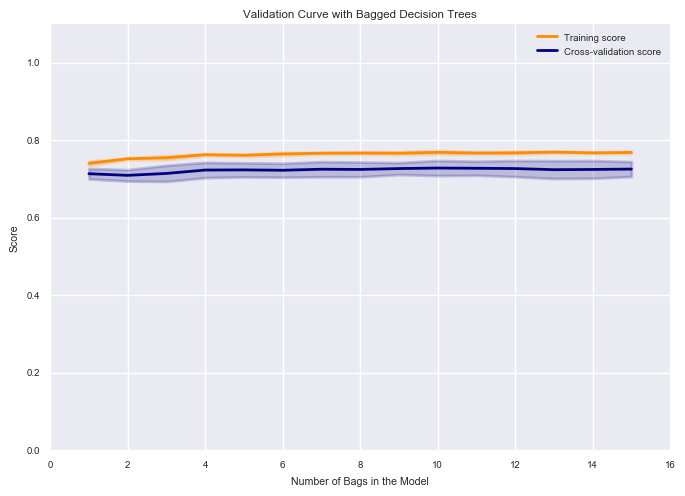

In [34]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import validation_curve

X, y = x_train[sorted_important_features_list[0:sel_count]].values, y_train['loss'].values

param_range = range(1,16)
train_scores, test_scores = validation_curve(
    BaggingClassifier(DecisionTreeClassifier(max_depth=7)),X, y, param_name="n_estimators", param_range=param_range,cv=10, scoring="accuracy", n_jobs=1,
    )    
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Bagged Decision Trees")
plt.xlabel("Number of Bags in the Model")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/dtrees_bagging_valid_curve.png")
plt.show()

# Tuning of Depth for Bagged Decision Trees.

The max accuracy for 100 top features 73.1612807439
The max accuracy for 200 top features 73.2183477829
The max accuracy for 300 top features 73.0854463657
The max accuracy for 400 top features 73.4475288718
The max accuracy for 500 top features 73.1997568334
The max accuracy for 600 top features 73.1045443044
The max accuracy for 700 top features 73.0276433931


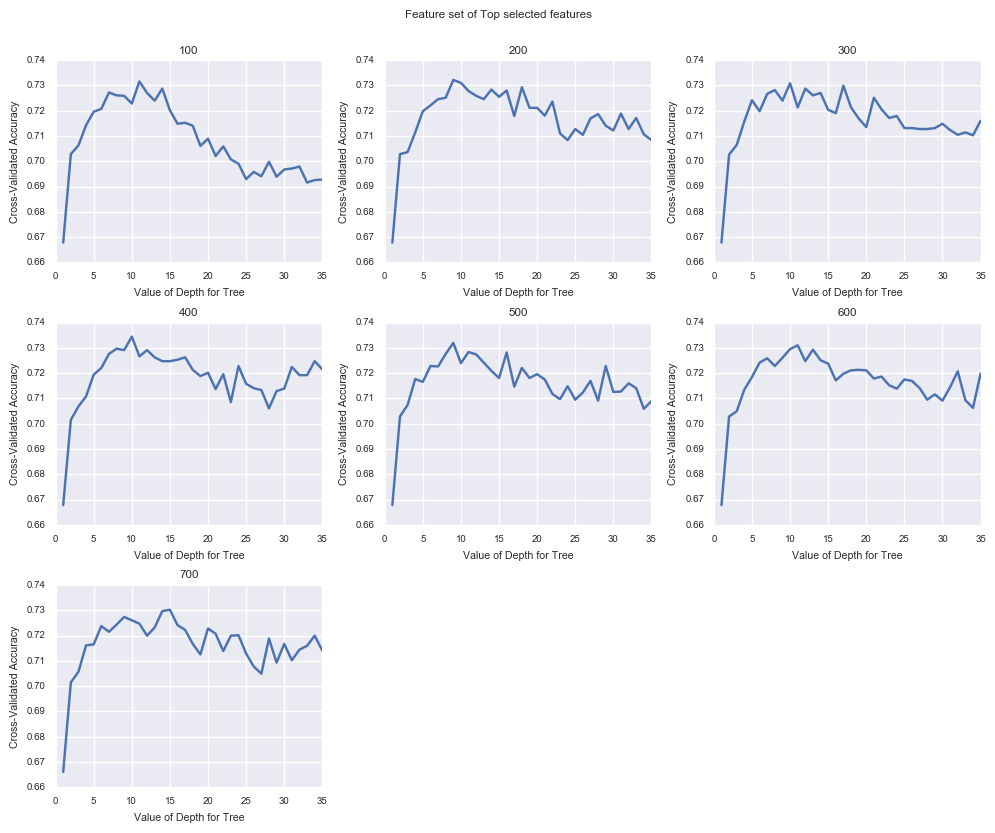

The top subset of features are: 400


In [48]:
from sklearn.tree import DecisionTreeClassifier


count = 1
plt.figure(figsize = (10,8))
dec_ftre_list = [];dec_score_list = [];
for i in range(100,800,100):
    features = sorted_important_features_list[:i]
    #print (features)
    k_range = range(1, 36)
    k_scores = []
    #print ("here 1")
    for k in k_range:
        tree = BaggingClassifier(DecisionTreeClassifier(max_depth=k))
        scores = cross_val_score(tree, x_train[features].values, y_train['loss'].values, cv=7, scoring='accuracy')
        #print ("here 2")
        k_scores.append(scores.mean())
    print("The max accuracy for",i,"top features",max(k_scores)*100)

    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    dec_ftre_list.append(str(i))
    dec_score_list.append(max(k_scores))
    plt.subplot(3, 3, count)
    count += 1
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of Depth for Tree')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title(i)
plt.suptitle('Feature set of Top selected features', y = 1.03)
plt.tight_layout()
plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/dtrees_bagging_optimality_curve.png")
plt.show()
sel_count_dict = dict(zip(dec_ftre_list,dec_score_list))
sel_count = int (max(sel_count_dict, key=sel_count_dict.get))
print ("The top subset of features are:",sel_count)

# Bias Variance Analysis of Boosted Decison Trees.

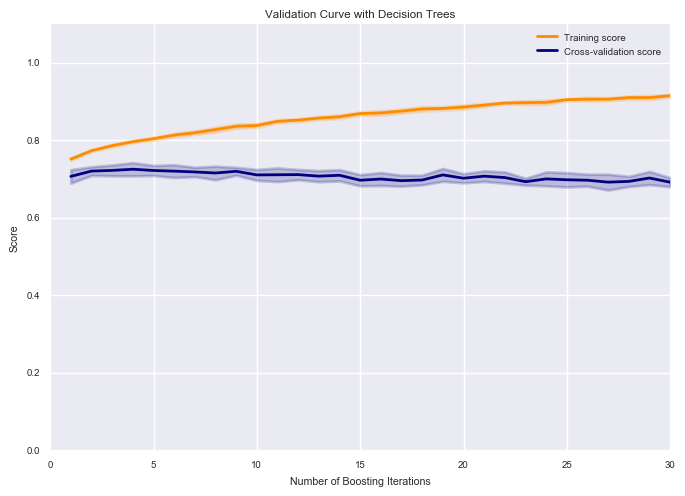

In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import validation_curve

X, y = x_train[sorted_important_features_list[0:sel_count]].values, y_train['loss'].values

param_range = range(1,31)
train_scores, test_scores = validation_curve(
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=7)),X, y, param_name="n_estimators", param_range=param_range,cv=10, scoring="accuracy", n_jobs=1,
    )    
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Decision Trees")
plt.xlabel("Number of Boosting Iterations")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/dtrees_boosting_valid_curve.png")
plt.show()

# Training and Prediction: Bagged Decision Trees

## The accuracy could vary from the report because the bootstrap samples may vary

The accuracy of the classifier is 73.2571428571
The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}
The confusion matrix for the classifier:
[[699 199]
 [269 583]]
The number of true negatives: 699
The number of false negatives: 269
The number of false positive: 199
The number of true positive: 583
The True Positive Rate for the Model: 0.684272300469
The False Positive Rate for the Model: 0.221603563474


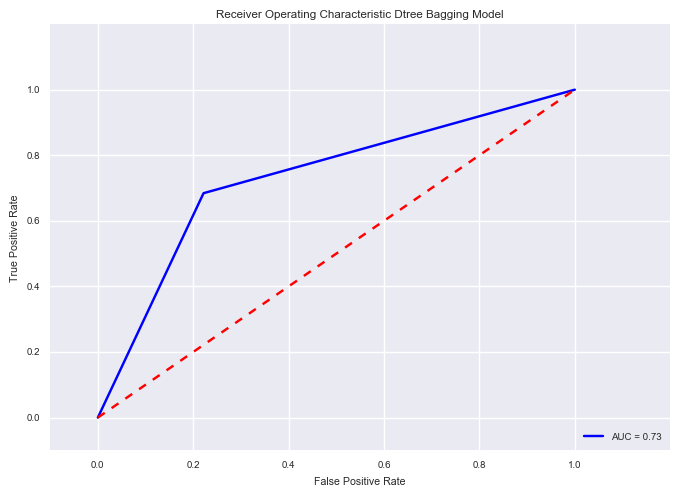

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
sel_count_bag = 400
tree_bagger = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=14),bootstrap_features = True)
tree_bagger.fit(x_train[sorted_important_features_list[0:sel_count_bag]].values, y_train['loss'].values)
y_pred_2_bagger = tree_bagger.predict(x_test[sorted_important_features_list[0:sel_count_bag]].values)
print("The accuracy of the classifier is",metrics.accuracy_score(y_test, y_pred_2_bagger)*100)

print ("The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}")
print ("The confusion matrix for the classifier:")
confusion_matrix_2_bagger  =  confusion_matrix(y_test, y_pred_2_bagger)
print (confusion_matrix_2_bagger)

print ("The number of true negatives:",confusion_matrix_2_bagger[0][0])
print ("The number of false negatives:",confusion_matrix_2_bagger[1][0])
print ("The number of false positive:",confusion_matrix_2_bagger[0][1])
print ("The number of true positive:",confusion_matrix_2_bagger[1][1])
print ("The True Positive Rate for the Model:",(confusion_matrix_2_bagger[1][1])/(confusion_matrix_2_bagger[1][1] + confusion_matrix_2_bagger[1][0]))
print ("The False Positive Rate for the Model:",(confusion_matrix_2_bagger[0][1])/(confusion_matrix_2_bagger[0][1] + confusion_matrix_2_bagger[0][0]))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_2_bagger)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic Dtree Bagging Model')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/dtree_bagger_roc.png")
plt.show()


# Tuning of Smoothing Parameter: Naive Bayes Classifier

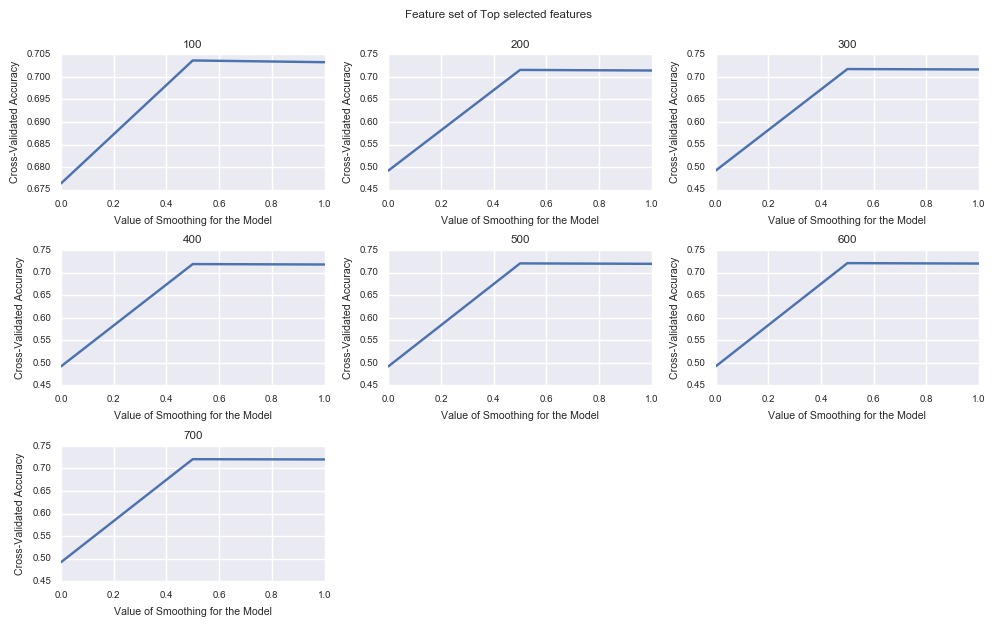

The top subset of features are: 600


In [40]:
from sklearn.naive_bayes import BernoulliNB

count = 1
plt.figure(figsize = (10,6))
alpha_ftre_list = [];alpha_score_list = [];
for i in range(100,800,100):
    #print ("here 2")
    features = sorted_important_features_list[:i]
    #print (features)
    k_range = [0,0.5,1]
    k_scores = []
    for k in k_range:
        tree = BernoulliNB(alpha=k)
        scores = cross_val_score(tree, x_train[features].values, y_train['loss'].values, cv=7, scoring='accuracy')
       
        k_scores.append(scores.mean())
    #print("The max accuracy for",i,"top features",max(k_scores)*100)

    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    alpha_ftre_list.append(str(i))
    alpha_score_list.append(max(k_scores))
    plt.subplot(3, 3, count)
    count += 1
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of Smoothing for the Model')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title(i)
plt.suptitle('Feature set of Top selected features', y = 1.03)
plt.tight_layout()
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/nb_alpha_tuning.png")
plt.show()
alpha_count_dict = dict(zip(alpha_ftre_list,alpha_score_list))
alpha_count = int (max(alpha_count_dict, key=alpha_count_dict.get))

print ("The top subset of features are:",alpha_count)


# Training and Prediction: Naive Bayes Classifier

The accuracy of the classifier (NAIVE BAYES) is: 73.4857142857
The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}
The confusion matrix for the classifier:
[[715 183]
 [281 571]]
The True Positive Rate for the Model: 0.670187793427
The False Positive Rate for the Model: 0.203786191537
The number of true negatives: 715
The number of false negatives: 281
The number of false positive: 183
The number of true positive: 571


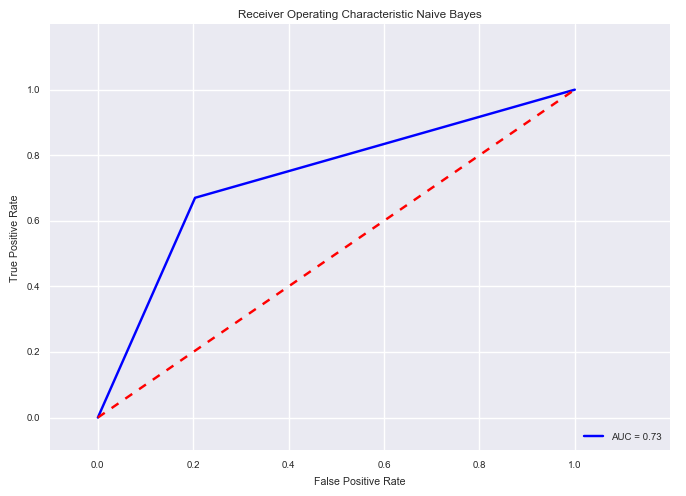

In [41]:
from sklearn.naive_bayes import BernoulliNB
naive_bayes = BernoulliNB(alpha = 1)
naive_bayes.fit(x_train[sorted_important_features_list[0:alpha_count]].values, y_train['loss'].values)
y_pred_4 = naive_bayes.predict(x_test[sorted_important_features_list[0:alpha_count]].values)
print("The accuracy of the classifier (NAIVE BAYES) is:",metrics.accuracy_score(y_test, y_pred_4)*100)

print ("The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}")
print ("The confusion matrix for the classifier:")
confusion_matrix_4 =  confusion_matrix(y_test, y_pred_4)
print (confusion_matrix_4)

print ("The True Positive Rate for the Model:",(confusion_matrix_4[1][1])/(confusion_matrix_4[1][1] + confusion_matrix_4[1][0]))
print ("The False Positive Rate for the Model:",(confusion_matrix_4[0][1])/(confusion_matrix_4[0][1] + confusion_matrix_4[0][0]))
print ("The number of true negatives:",confusion_matrix_4[0][0])
print ("The number of false negatives:",confusion_matrix_4[1][0])
print ("The number of false positive:",confusion_matrix_4[0][1])
print ("The number of true positive:",confusion_matrix_4[1][1])

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_4)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic Naive Bayes')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/ROC_naive_bayes.png")
plt.show()

# Tuning the 'C' parameter in Logistic Regression:

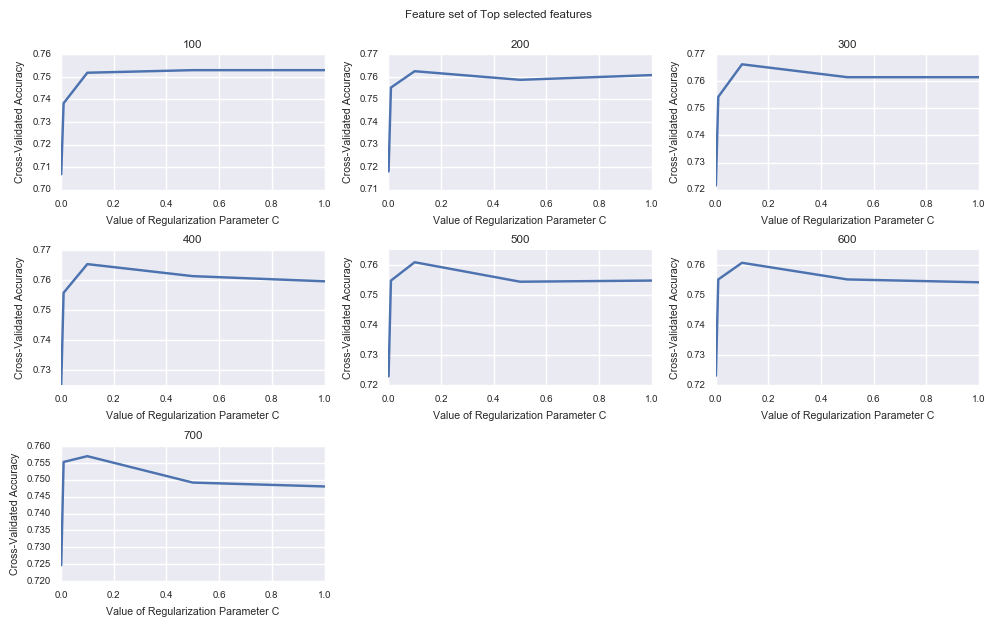

The top subset of features are: 300


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

count = 1
plt.figure(figsize = (10,6))
c_ftre_list = [];c_score_list = [];
for i in range(100,800,100):
    #print ("here 2")
    features = sorted_important_features_list[:i]
    #print (features)
    k_range = [0.001,0.01, 0.1,0.5, 1]
    k_scores = []
    for k in k_range:
        tree = LogisticRegression(penalty = 'l2', C = k)
        scores = cross_val_score(tree, x_train[features].values, y_train['loss'].values, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())
    #print("The max accuracy for",i,"top features",max(k_scores)*100)

    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    c_ftre_list.append(str(i))
    c_score_list.append(max(k_scores))
    plt.subplot(3, 3, count)
    count += 1
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of Regularization Parameter C')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title(i)
plt.suptitle('Feature set of Top selected features', y = 1.03)
plt.tight_layout()
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/logreg_c_tuning.png")
plt.show()
c_count_dict = dict(zip(c_ftre_list,c_score_list))
c_count = int (max(c_count_dict, key=c_count_dict.get))

print ("The top subset of features are:",c_count)


# Bias Variance Analysis Logistic Regression

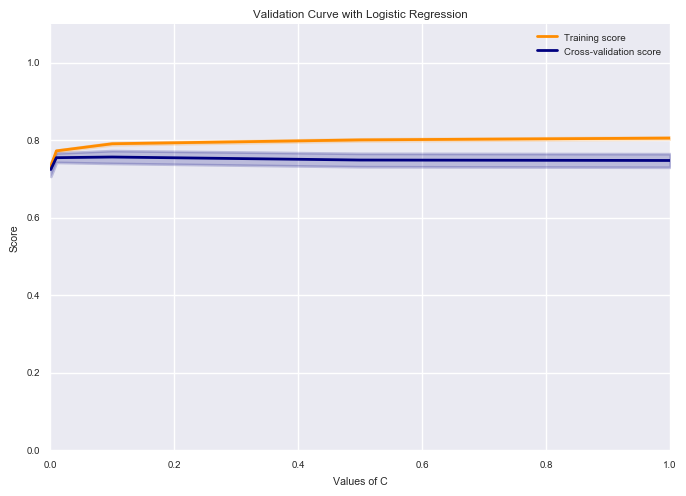

In [43]:

from sklearn.model_selection import validation_curve

X, y = x_train[sorted_important_features_list[0:700]].values, y_train['loss'].values

param_range = [0.001,0.01, 0.1,0.5, 1]
train_scores, test_scores = validation_curve(LogisticRegression(penalty = 'l2'),X, y, param_name="C", param_range=param_range,cv=10, scoring="accuracy", n_jobs=1,
    )    
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic Regression")
plt.xlabel("Values of C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/logreg_valid_curve_700.png")
plt.show()

# Training and Prediction: Logistic Regression

The accuracy of the classifier (LOGISTIC REGRESSION) is: 75.4857142857
The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}
The confusion matrix for the classifier:
[[719 179]
 [250 602]]
The True Positive Rate for the Model: 0.706572769953
The False Positive Rate for the Model: 0.199331848552
The number of true negatives: 719
The number of false negatives: 250
The number of false positive: 179
The number of true positive: 602


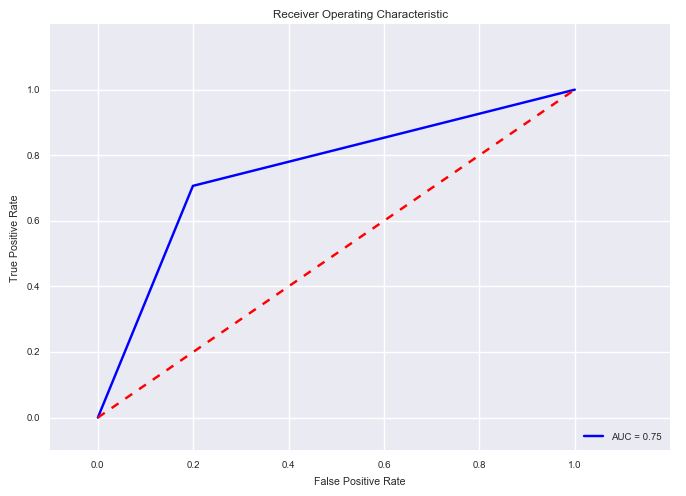

In [45]:
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
tuned_logreg = LogisticRegression(penalty =  'l2',C =  0.01,class_weight = "balanced")

tuned_logreg.fit(x_train[sorted_important_features_list[0:c_count]].values, y_train['loss'].values)
y_pred_3 = tuned_logreg.predict(x_test[sorted_important_features_list[0:c_count]].values)



print("The accuracy of the classifier (LOGISTIC REGRESSION) is:",metrics.accuracy_score(y_test, y_pred_3)*100)
print ("The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}")
print ("The confusion matrix for the classifier:")
confusion_matrix_3 =  confusion_matrix(y_test, y_pred_3)
print (confusion_matrix_3)

print ("The True Positive Rate for the Model:",(confusion_matrix_3[1][1])/(confusion_matrix_3[1][1] + confusion_matrix_3[1][0]))
print ("The False Positive Rate for the Model:",(confusion_matrix_3[0][1])/(confusion_matrix_3[0][1] + confusion_matrix_3[0][0]))

print ("The number of true negatives:",confusion_matrix_3[0][0])
print ("The number of false negatives:",confusion_matrix_3[1][0])
print ("The number of false positive:",confusion_matrix_3[0][1])
print ("The number of true positive:",confusion_matrix_3[1][1])

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_3)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/ROC_log_reg.png")
plt.show()



# Training and Prediction: Voting Classifier

The accuracy of the classifier  is: 0.764
The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}
The confusion matrix for the classifier:
[[726 172]
 [241 611]]
The True Positive Rate for the Model: 0.717136150235
The False Positive Rate for the Model: 0.19153674833
The number of true negatives: 726
The number of false negatives: 241
The number of false positive: 172
The number of true positive: 611


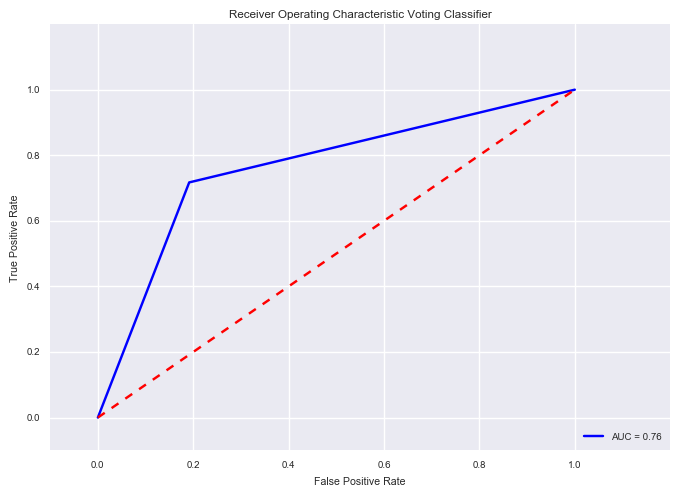

In [46]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import BernoulliNB

clf1 = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=13,weights = 'uniform'),n_estimators = 15,bootstrap_features = True)
clf2 = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=14),bootstrap_features = True)
clf3 = LogisticRegression(penalty =  'l2', C =  0.01,class_weight = "balanced")
clf4 = BernoulliNB(alpha = 1)

eclf = VotingClassifier(estimators=[('knn', clf1), ('rf', clf2),('lr', clf3), ('bnb', clf4)], voting='hard',weights=[2,10,20,0.5])
eclf.fit(x_train.values, y_train['loss'].values)
y_pred_main = eclf.predict(x_test)
print("The accuracy of the classifier  is:",metrics.accuracy_score(y_test, y_pred_main))
print ("The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}")
print ("The confusion matrix for the classifier:")
confusion_matrix_voting =  confusion_matrix(y_test, y_pred_main)
print (confusion_matrix_voting)

print ("The True Positive Rate for the Model:",(confusion_matrix_voting[1][1])/(confusion_matrix_voting[1][1] + confusion_matrix_voting[1][0]))
print ("The False Positive Rate for the Model:",(confusion_matrix_voting[0][1])/(confusion_matrix_voting[0][1] + confusion_matrix_voting[0][0]))

print ("The number of true negatives:",confusion_matrix_voting[0][0])
print ("The number of false negatives:",confusion_matrix_voting[1][0])
print ("The number of false positive:",confusion_matrix_voting[0][1])
print ("The number of true positive:",confusion_matrix_voting[1][1])

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_main)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic Voting Classifier')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/ROC_voting_classifier.png")
plt.show()

# Training and Prediction: Bagged Desicion Trees without Feature Engineering

The accuracy of the classifier  is: 72.4
The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}
The confusion matrix for the classifier:
[[692 206]
 [277 575]]
The True Positive Rate for the Model: 0.674882629108
The False Positive Rate for the Model: 0.229398663697
The number of true negatives: 692
The number of false negatives: 277
The number of false positive: 206
The number of true positive: 575


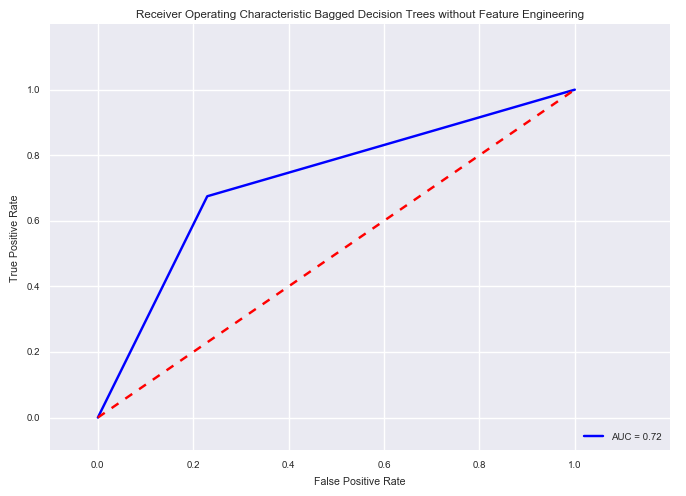

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble  import BaggingClassifier
from sklearn import metrics
base_logreg = BaggingClassifier()

base_logreg.fit(x_train.values, y_train['loss'].values)
y_pred_base = base_logreg.predict(x_test.values)



print("The accuracy of the classifier  is:",metrics.accuracy_score(y_test, y_pred_base)*100)
print ("The count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}")
print ("The confusion matrix for the classifier:")
confusion_matrix_base =  confusion_matrix(y_test, y_pred_base)
print (confusion_matrix_base)

print ("The True Positive Rate for the Model:",(confusion_matrix_base[1][1])/(confusion_matrix_base[1][1] + confusion_matrix_base[1][0]))
print ("The False Positive Rate for the Model:",(confusion_matrix_base[0][1])/(confusion_matrix_base[0][1] + confusion_matrix_base[0][0]))

print ("The number of true negatives:",confusion_matrix_base[0][0])
print ("The number of false negatives:",confusion_matrix_base[1][0])
print ("The number of false positive:",confusion_matrix_base[0][1])
print ("The number of true positive:",confusion_matrix_base[1][1])

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_base)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic Bagged Decision Trees without Feature Engineering')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/ROC_wtout_ftre_bagging.png")
plt.show()

# Comparing Linear and Non - Linear Classifiers

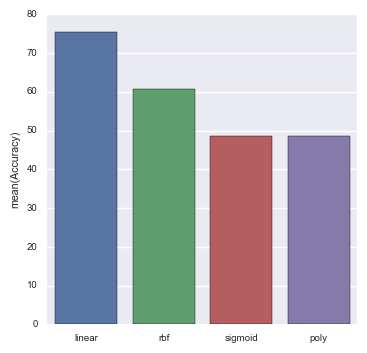

In [47]:
from sklearn import svm
svm_linear_count = 200
kernel_list = ['linear','rbf','sigmoid','poly']
svm_df = pd.DataFrame(columns = kernel_list,index=['Accuracy'])

for each_kernel in kernel_list:
    sup_nonlinear = svm.SVC( C = 0.01,kernel = each_kernel)
    sup_nonlinear.fit(x_train[sorted_important_features_list[0:svm_linear_count]].values, y_train['loss'].values)
    y_pred_nonlinearsvm = sup_nonlinear.predict(x_test[sorted_important_features_list[0:svm_linear_count]].values)
    accuracy = metrics.accuracy_score(y_test, y_pred_nonlinearsvm)*100
    svm_df[each_kernel] = accuracy

    
plt.figure(figsize = (4,4))
sns.barplot(svm_df.columns, svm_df.loc['Accuracy'])
#plt.savefig("/Users/vigneshsureshbabu/Documents/AML/Kaggle/alstate/figs/svm_nonlinear_analysis.png")

# Analyzing the Indepndance of  Features for Naive Bayes 


In [ ]:
df_naive_bayes = x_train[sorted_important_features_list[0:10]]
df_naive_bayes_corr = df_naive_bayes.corr()
plt.subplots(figsize=(21, 11))
sns.heatmap(df_naive_bayes_corr,annot=True)
plt.show()